# Dataset Generation

Digit -> color-digit -> color-bar

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import os
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import normflows as nf
import numpy as np
import scipy.stats
import seaborn as sns
import torch
import torchvision
import torchvision.datasets.utils as dataset_utils
import torchvision.transforms.functional as F
from joblib import Parallel, delayed
from PIL import Image
from scipy import stats
from scipy.stats import truncnorm
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

from gendis.datasets import MultiDistrDataModule, alter_digitbar_img, bar_digit_scm
from gendis.datasets.causalbarmnist import (
    CausalBarMNIST,
    add_bar,
    bar_scm,
    create_altered_mnist_dataset,
    value_to_rgb,
)
from gendis.datasets.morphomnist import morpho, perturb
from gendis.datasets.utils import show_imgs

plt.rcParams["savefig.bbox"] = "tight"
import numpy as np
import seaborn as sns

In [9]:
root = "/Users/adam2392/pytorch_data/"

# set up transforms for each image to augment the dataset
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        # nf.utils.Scale(255.0 / 256.0),  # normalize the pixel values
        # nf.utils.Jitter(1 / 256.0),  # apply random generation
        # torchvision.transforms.RandomRotation(350),  # get random rotations
    ]
)

mnist_data = MNIST(root, train=True, download=True, transform=transform)

images = mnist_data.data
labels = mnist_data.targets

print(len(images))

60000


<Axes: ylabel='Count'>

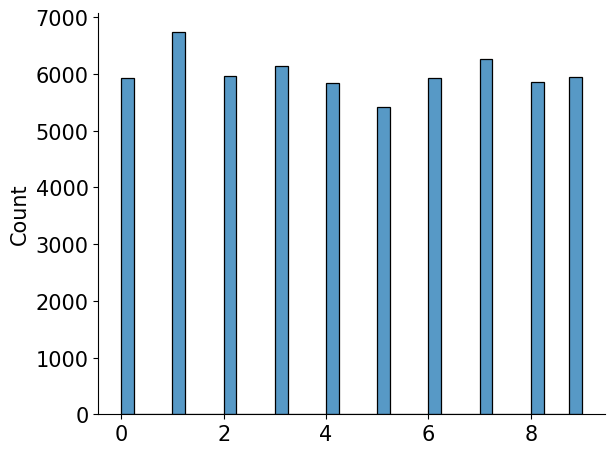

In [10]:
sns.histplot(labels)

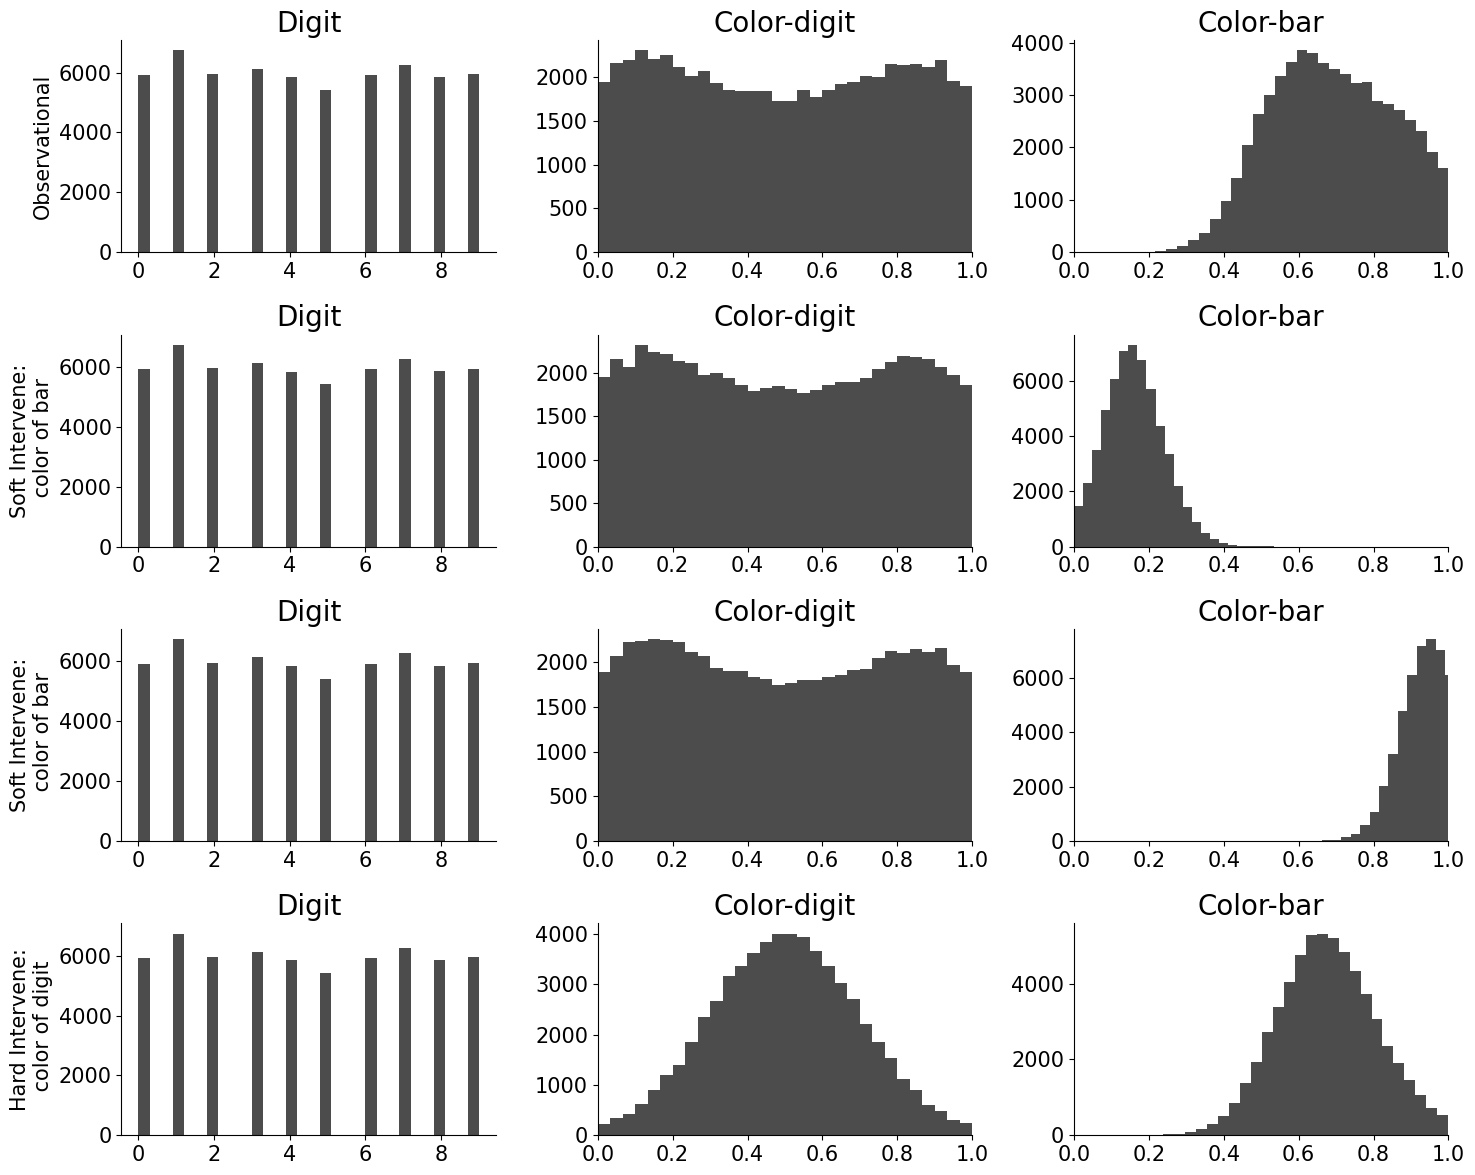

In [11]:
sns.set_context("paper", font_scale=2.0)

# Plotting the distributions
fig, axes = plt.subplots(4, 3, figsize=(15, 12), sharex=False, sharey=False)
for idx in range(4):
    causal_labels = bar_digit_scm(intervention_idx=idx, labels=labels)
    if idx == 0:
        setting = "Observational"
    elif idx == 1:
        setting = "Soft Intervene:\n color of bar"
    elif idx == 2:
        setting = "Soft Intervene:\n color of bar"
    elif idx == 3:
        setting = "Hard Intervene:\n color of digit"
    axes[idx, 0].set_ylabel(f"{setting}")

    digit = causal_labels["digit"]
    color_digit = causal_labels["color_digit"]
    color_bar = causal_labels["color_bar"]

    axes[idx, 0].hist(digit, bins=30, color="black", alpha=0.7)
    axes[idx, 0].set_title(f"Digit")
    axes[idx, 1].hist(color_digit, bins=30, color="black", alpha=0.7)
    axes[idx, 1].set_title(f"Color-digit")
    axes[idx, 1].set_xlim([0, 1])
    axes[idx, 2].hist(color_bar, bins=30, color="black", alpha=0.7)
    axes[idx, 2].set_title(f"Color-bar")
    axes[idx, 2].set_xlim([0, 1])

plt.tight_layout()
plt.show()

In [18]:
img_dataset = []
labels_dataset = None

for intervention_idx in [0, 1, 2, 3]:
    causal_labels = bar_digit_scm(intervention_idx=intervention_idx, labels=labels)
    causal_labels["distr_idx"] = torch.Tensor([intervention_idx] * len(labels))

    # ensure all tensors are 2D so vstackable
    keys = causal_labels.keys()
    for key in keys:
        if causal_labels[key].ndim == 1:
            causal_labels[key] = causal_labels[key].reshape(-1, 1)

    if labels_dataset is None:
        labels_dataset = causal_labels
    else:
        keys = list(causal_labels.keys())
        for key in keys:
            labels_dataset[key] = torch.vstack(
                (labels_dataset[key], causal_labels[key])
            )

    for idx, img in enumerate(images):
        color_bar = causal_labels["color_bar"][idx]
        color_digit = causal_labels["color_digit"][idx]

        new_img = alter_digitbar_img(img, color_digit, color_bar, dtype="PIL")
        img_dataset.append(new_img)

        # Uncomment to show the images
        if idx >= 7:
            break

img_dataset = torch.vstack(
    [
        torchvision.transforms.functional.pil_to_tensor(x).reshape(1, 3, 28, 28)
        for x in img_dataset
    ]
)

print(img_dataset.shape)
print(labels_dataset.keys())

torch.Size([32, 3, 28, 28])
dict_keys(['intervention_targets', 'digit', 'color_digit', 'color_bar', 'distr_idx'])


torch.Size([32, 3, 28, 28])
8 4


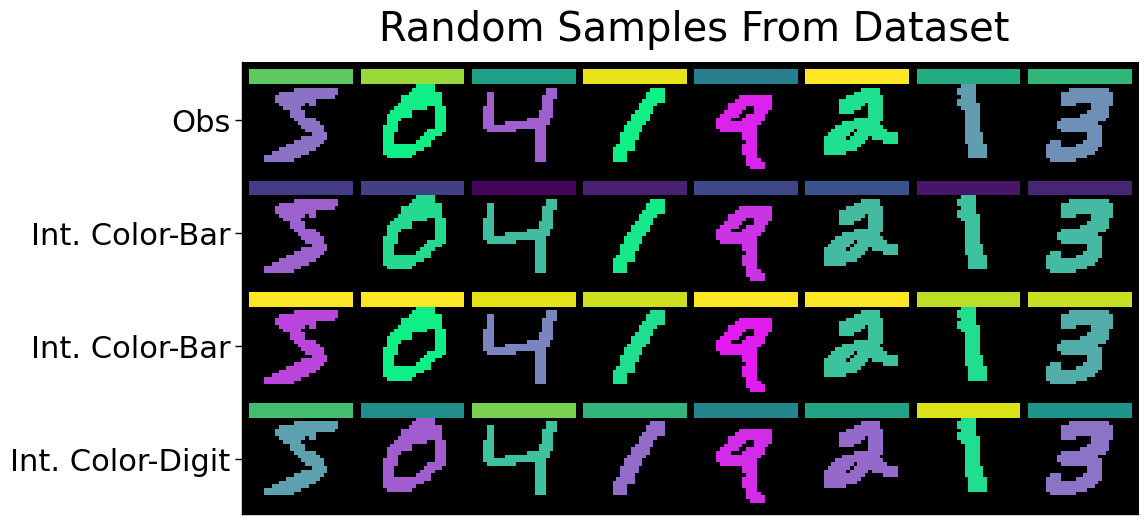

In [32]:
print(img_dataset.shape)
sns.set_context("paper", font_scale=2.5)
fig, ax = show_imgs(
    img_dataset,
    row_size=8,
    ytick_labels=["Obs", "Int. Color-Bar", "Int. Color-Bar", "Int. Color-Digit"],
)
fig.suptitle("Random Samples From Dataset", x=0.6, y=0.9)
fig.savefig("/Users/adam2392/Downloads/sample_dataset.pdf", bbox_inches="tight")

# Create the actual dataset and save to disc

In [34]:
img_dataset = []
labels_dataset = None

for intervention_idx in [0, 1, 2, 3]:
    causal_labels = bar_digit_scm(intervention_idx=intervention_idx, labels=labels)
    causal_labels["distr_idx"] = torch.Tensor([intervention_idx] * len(labels))

    # ensure all tensors are 2D so vstackable
    for key in keys:
        if causal_labels[key].ndim == 1:
            causal_labels[key] = causal_labels[key].reshape(-1, 1)

    if labels_dataset is None:
        labels_dataset = causal_labels
    else:
        keys = list(causal_labels.keys())
        for key in keys:
            labels_dataset[key] = torch.vstack(
                (labels_dataset[key], causal_labels[key])
            )

    for idx, img in enumerate(images):
        color_bar = causal_labels["color_bar"][idx]
        color_digit = causal_labels["color_digit"][idx]

        new_img = alter_digitbar_img(img, color_digit, color_bar)
        new_img = Image.fromarray(new_img, mode="RGB")
        img_dataset.append(new_img)


# img_dataset = torch.vstack(
#     [
#         torchvision.transforms.functional.pil_to_tensor(x).reshape(1, 3, 28, 28)
#         for x in img_dataset
#     ]
# )

# print(img_dataset.shape)
print(labels_dataset.keys())
keys = ["digit", "color_digit", "color_bar", "distr_idx"]
label_tensor = torch.zeros((len(img_dataset), len(keys)))
# convert the labels from a list of dictionaries to a tensor array
for idx, key in enumerate(keys):
    label_tensor[:, idx] = torch.Tensor(labels_dataset[key]).squeeze()
print(label_tensor.shape)

dict_keys(['intervention_targets', 'digit', 'color_digit', 'color_bar', 'distr_idx'])
torch.Size([240000, 4])


In [35]:
intervention_target_tensor = torch.zeros((len(img_dataset), 3), dtype=torch.int)
intervention_target_tensor[:] = torch.Tensor(labels_dataset["intervention_targets"])
print(intervention_target_tensor.shape)
print(root)

torch.Size([240000, 3])
/Users/adam2392/pytorch_data/


In [36]:
# save the actual data to disc now
root = Path(root)
imgs_fname = root / "CausalDigitBarMNIST" / "chainv2" / "chain-imgs-train.pt"
labels_fname = root / "CausalDigitBarMNIST" / "chainv2" / "chain-labels-train.pt"
targets_fname = root / "CausalDigitBarMNIST" / "chainv2" / "chain-targets-train.pt"
imgs_fname.parent.mkdir(exist_ok=True, parents=True)

torch.save(img_dataset, imgs_fname)
torch.save(label_tensor, labels_fname)
torch.save(intervention_target_tensor, targets_fname)

# V1 vs V2 dataset

V1 uses the datset from this commit: https://github.com/tree1111/CDRL/blob/digit_data_geenration/notebooks/dataset%20generate%20v2.ipynb

V2 uses a new dataset with more causal dependency

In [39]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import torch
from joblib import Parallel, delayed
from PIL import Image
from scipy.stats import truncnorm
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

from gendis.datasets.morphomnist import morpho, perturb


def truncated_normal(mean, std, lower, upper, size):
    a, b = (lower - mean) / std, (upper - mean) / std
    samples = truncnorm.rvs(a, b, loc=mean, scale=std, size=size)
    return torch.tensor(samples, dtype=torch.float32)


def skewed_normal(mode, skewness, size):
    alpha = skewness
    loc = mode
    scale = 0.1  # Adjust scale as necessary
    samples = scipy.stats.skewnorm.rvs(a=alpha, loc=loc, scale=scale, size=size)
    return torch.tensor(samples, dtype=torch.float32)


def bar_digit_scm(intervention_idx, labels):
    """Generate parameters for the SCM of the MNIST dataset with a bar.

    There are four possible distributions that are generated. The first is observational
    (intervention_idx == 0):

        - digit is just uniformly distributed more or less in the MNIST dataset
        - color-digit will be a mixture of gaussians, where the mean is evenly
        spaced from 0 to 1 depending on the digit, and the standard deviation
        is a default value of 0.1 for each digit
        - color-bar will be a function of color-digit, sampled from a truncated
        normal distribution with mean equal to the color-digit value and a standard
        deviation of 0.1

    Intervention 1 (color-bar) is changed:
        - color-bar will be sampled from a truncated normal distribution with
        mean equal to 1 - color-digit and a standard deviation of 0.1

    Intervention 2 (color-bar) is changed:
        - color-bar will be sampled from a skewed distribution towards
        0.9.

    Parameters
    ----------
    intervention_idx : int
        The intervention index.
    labels : tensor of shape (n_samples,)
        The labels of each of the MNIST digit samples. This corresponds to the
        digit.

    Returns
    -------
    causal_labels : dict
        A dictionary of:
            - digit : tensor of shape (n_samples,)
                The digit label.
            - color_digit : tensor of shape (n_samples,)
                The value of the color-digit from [0, 1].
            - color_bar : tensor of shape (n_samples,)
                The value of the color-digit from [0, 1].
    """
    n_samples = labels.shape[0]

    # Digit is just uniformly distributed more or less in the MNIST dataset
    digit = torch.Tensor(labels)

    # Color-digit will be a mixture of gaussians
    color_digit_means = torch.linspace(
        0, 1, 10
    )  # 10 possible digits, evenly spaced means from 0 to 1
    color_digit_stds = 0.05 * torch.ones(10)  # Standard deviation of 0.1 for each digit
    color_digit = torch.zeros(n_samples)

    for i in range(10):
        mask = digit == i
        num_samples = mask.sum().item()
        color_digit[mask] = torch.distributions.Normal(
            color_digit_means[i], color_digit_stds[i]
        ).sample((num_samples,))

    causal_labels = dict()
    # Generate color_bar based on the intervention index
    if intervention_idx == 0:
        # Observational distribution
        color_bar = truncated_normal(0.5, 1.0 / (color_digit + 0.5), 0, 1, n_samples)
        causal_labels["intervention_targets"] = torch.Tensor([[0, 0, 0]] * n_samples)
    elif intervention_idx == 1:
        # Intervention 1: mean equal to 1 - color-digit
        # color_bar = truncated_normal(1 - color_digit, 0.1, 0, 1, n_samples)
        # Intervention 2: skewed distribution towards 0.9
        color_bar = skewed_normal(0.1, 1.0 / (color_digit + 0.5), n_samples)
        causal_labels["intervention_targets"] = torch.Tensor([[0, 0, 1]] * n_samples)
    elif intervention_idx == 2:
        # Intervention 2: skewed distribution towards 0.9
        color_bar = skewed_normal(0.9, 1.0 / (color_digit + 0.5), n_samples)
        causal_labels["intervention_targets"] = torch.Tensor([[0, 0, 1]] * n_samples)
    else:
        raise ValueError("Invalid intervention_idx. Must be 0, 1, or 2.")

    causal_labels.update(
        {"digit": digit, "color_digit": color_digit, "color_bar": color_bar}
    )

    return causal_labels

In [42]:
def bar_digit_scm(intervention_idx, labels):
    """Generate parameters for the SCM of the MNIST dataset with a bar.

    There are four possible distributions that are generated. The first is observational
    (intervention_idx == 0):

        - digit is just uniformly distributed more or less in the MNIST dataset
        - color-digit will be a mixture of gaussians, where the mean is evenly
        spaced from 0 to 1 depending on the digit, and the standard deviation
        is a default value of 0.1 for each digit
        - color-bar will be a function of color-digit, sampled from a truncated
        normal distribution with mean equal to the color-digit value and a standard
        deviation of 0.1

    Intervention 1 (color-bar) is changed:
        - color-bar will be sampled from a truncated normal distribution with
        mean equal to 1 - color-digit and a standard deviation of 0.1

    Intervention 2 (color-bar) is changed:
        - color-bar will be sampled from a skewed distribution towards
        0.9.

    Parameters
    ----------
    intervention_idx : int
        The intervention index.
    labels : tensor of shape (n_samples,)
        The labels of each of the MNIST digit samples. This corresponds to the
        digit.

    Returns
    -------
    causal_labels : dict
        A dictionary of:
            - digit : tensor of shape (n_samples,)
                The digit label.
            - color_digit : tensor of shape (n_samples,)
                The value of the color-digit from [0, 1].
            - color_bar : tensor of shape (n_samples,)
                The value of the color-digit from [0, 1].
    """
    n_samples = labels.shape[0]

    # Digit is just uniformly distributed more or less in the MNIST dataset
    digit = torch.Tensor(labels)

    # Color-digit will be a mixture of gaussians
    color_digit_means = torch.linspace(
        0, 1, 10
    )  # 10 possible digits, evenly spaced means from 0 to 1
    color_digit_stds = 0.15 * torch.ones(10)  # Standard deviation of 0.1 for each digit
    color_digit = torch.zeros(n_samples)

    for i in range(10):
        mask = digit == i
        num_samples = mask.sum().item()
        # color_digit[mask] = torch.distributions.Normal(
        #     color_digit_means[i], color_digit_stds[i]
        # ).sample((num_samples,))
        color_digit[mask] = truncated_normal(
            color_digit_means[i], color_digit_stds[i], 0, 1, num_samples
        )

    causal_labels = dict()
    # Generate color_bar based on the intervention index
    if intervention_idx == 0:
        # Observational distribution
        color_bar = truncated_normal(0.5, 1.0 / (color_digit + 1), 0, 1, n_samples)
        causal_labels["intervention_targets"] = torch.Tensor([[0, 0, 0]] * n_samples)
    elif intervention_idx == 1:
        # Intervention 1: mean equal to 1 - color-digit
        # color_bar = truncated_normal(1 - color_digit, 0.1, 0, 1, n_samples)
        # Intervention 2: skewed distribution towards 0.9
        color_bar = skewed_normal(0.1, 1.0 / (color_digit + 0.5), n_samples)
        causal_labels["intervention_targets"] = torch.Tensor([[0, 0, 1]] * n_samples)
    elif intervention_idx == 2:
        # Intervention 2: skewed distribution towards 0.9
        color_bar = skewed_normal(0.9, 1.0 / (color_digit + 1), n_samples)
        causal_labels["intervention_targets"] = torch.Tensor([[0, 0, 1]] * n_samples)
    elif intervention_idx == 3:
        # Intervention 3: hard normal distribution on volor_digit
        n_samples = labels.shape[0]
        color_digit = truncated_normal(0.5, 0.4, 0, 1, n_samples)
        color_bar = truncated_normal(0.5, 1.0 / (color_digit + 0.5), 0, 1, n_samples)
        causal_labels["intervention_targets"] = torch.Tensor([[0, 0, 0]] * n_samples)
    else:
        raise ValueError("Invalid intervention_idx. Must be 0, 1, 2 or 3.")

    causal_labels.update(
        {"digit": digit, "color_digit": color_digit, "color_bar": color_bar}
    )

    return causal_labels

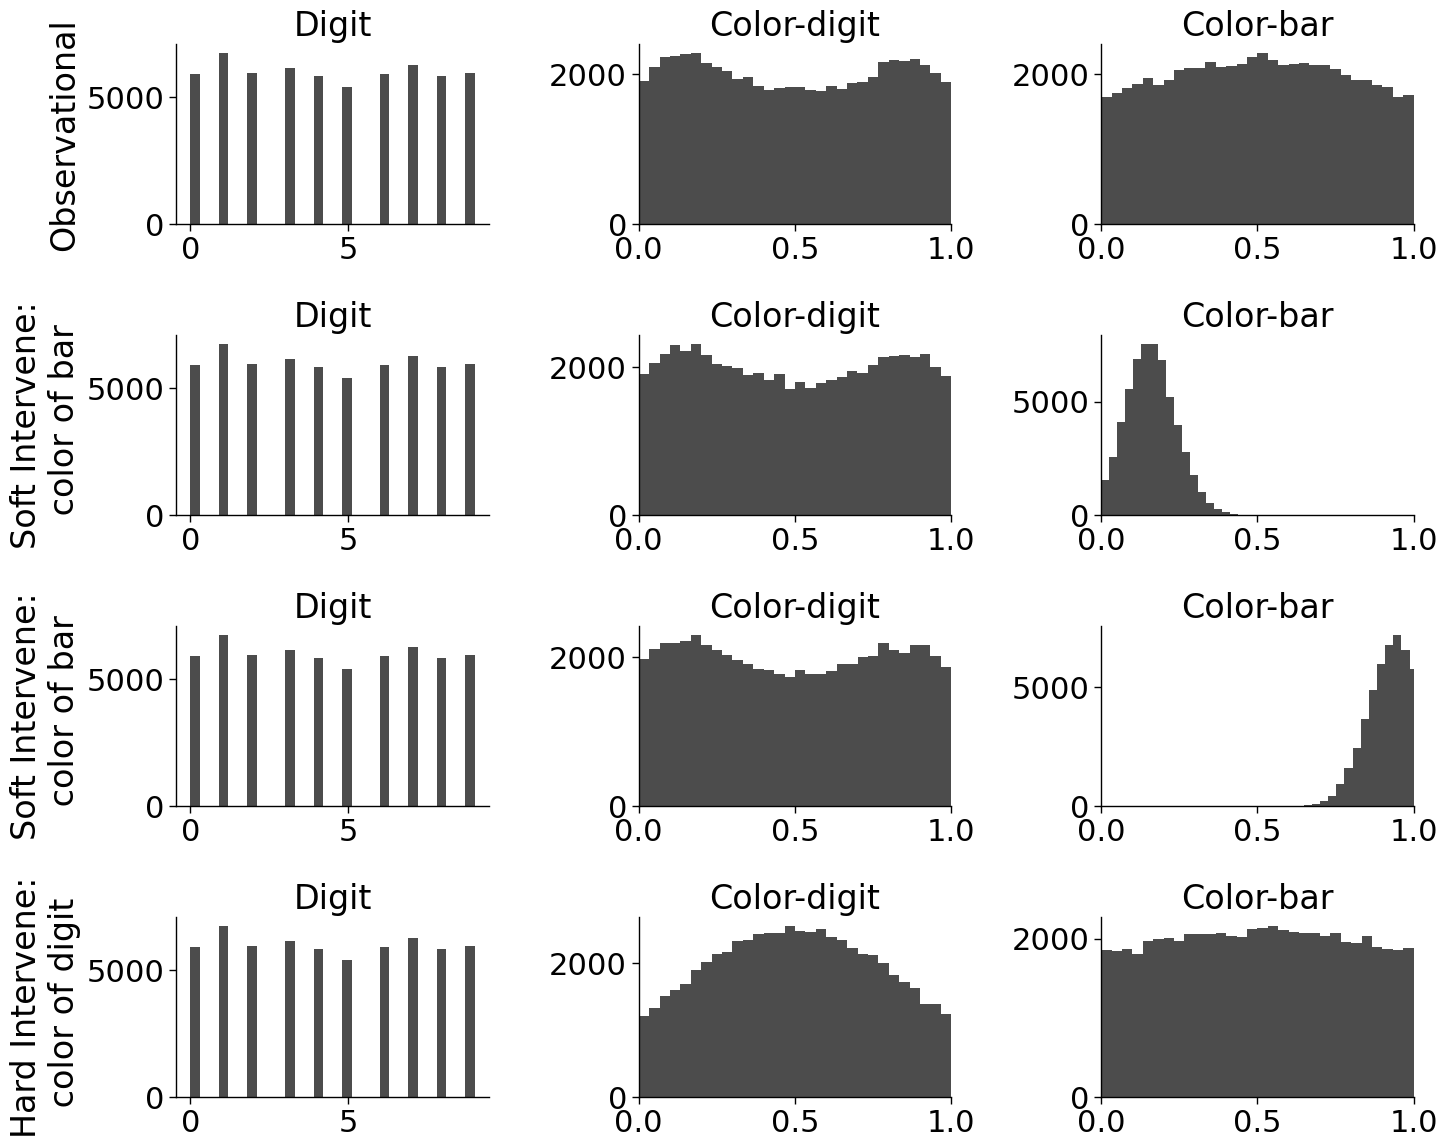

In [44]:
# Plotting the distributions
fig, axes = plt.subplots(4, 3, figsize=(15, 12), sharex=False, sharey=False)
for idx in range(4):
    causal_labels = bar_digit_scm(intervention_idx=idx, labels=labels)
    if idx == 0:
        setting = "Observational"
    elif idx == 1:
        setting = "Soft Intervene:\n color of bar"
    elif idx == 2:
        setting = "Soft Intervene:\n color of bar"
    elif idx == 3:
        setting = "Hard Intervene:\n color of digit"
    axes[idx, 0].set_ylabel(f"{setting}")

    digit = causal_labels["digit"]
    color_digit = causal_labels["color_digit"]
    color_bar = causal_labels["color_bar"]

    axes[idx, 0].hist(digit, bins=30, color="black", alpha=0.7)
    axes[idx, 0].set_title(f"Digit")
    axes[idx, 1].hist(color_digit, bins=30, color="black", alpha=0.7)
    axes[idx, 1].set_title(f"Color-digit")
    axes[idx, 1].set_xlim([0, 1])
    axes[idx, 2].hist(color_bar, bins=30, color="black", alpha=0.7)
    axes[idx, 2].set_title(f"Color-bar")
    axes[idx, 2].set_xlim([0, 1])

plt.tight_layout()
plt.show()

In [45]:
img_dataset = []
labels_dataset = None

for intervention_idx in [0, 1, 2, 3]:
    print("Intervention idx ", intervention_idx)
    causal_labels = bar_digit_scm(intervention_idx=intervention_idx, labels=labels)
    causal_labels["distr_idx"] = torch.Tensor([intervention_idx] * len(labels))

    # ensure all tensors are 2D so vstackable
    for key in keys:
        if causal_labels[key].ndim == 1:
            causal_labels[key] = causal_labels[key].reshape(-1, 1)

    if labels_dataset is None:
        labels_dataset = causal_labels
    else:
        keys = list(causal_labels.keys())
        for key in keys:
            labels_dataset[key] = torch.vstack(
                (labels_dataset[key], causal_labels[key])
            )

    for idx, img in enumerate(images):
        color_bar = causal_labels["color_bar"][idx]
        color_digit = causal_labels["color_digit"][idx]

        new_img = alter_digitbar_img(img, color_digit, color_bar)
        new_img = Image.fromarray(new_img, mode="RGB")
        img_dataset.append(new_img)


# img_dataset = torch.vstack(
#     [
#         torchvision.transforms.functional.pil_to_tensor(x).reshape(1, 3, 28, 28)
#         for x in img_dataset
#     ]
# )

# print(img_dataset.shape)
print(labels_dataset.keys())
keys = ["digit", "color_digit", "color_bar", "distr_idx"]
label_tensor = torch.zeros((len(img_dataset), len(keys)))
# convert the labels from a list of dictionaries to a tensor array
for idx, key in enumerate(keys):
    label_tensor[:, idx] = torch.Tensor(labels_dataset[key]).squeeze()
print(label_tensor.shape)

intervention_target_tensor = torch.zeros((len(img_dataset), 3), dtype=torch.int)
intervention_target_tensor[:] = torch.Tensor(labels_dataset["intervention_targets"])
print(intervention_target_tensor.shape)
print(root)

Intervention idx  0
Intervention idx  1
Intervention idx  2
Intervention idx  3
dict_keys(['intervention_targets', 'digit', 'color_digit', 'color_bar', 'distr_idx'])
torch.Size([240000, 4])
torch.Size([240000, 3])
/Users/adam2392/pytorch_data


In [46]:
# save the actual data to disc now
root = Path(root)
imgs_fname = root / "CausalDigitBarMNIST" / "chainv1" / "chain-imgs-train.pt"
labels_fname = root / "CausalDigitBarMNIST" / "chainv1" / "chain-labels-train.pt"
targets_fname = root / "CausalDigitBarMNIST" / "chainv1" / "chain-targets-train.pt"
imgs_fname.parent.mkdir(exist_ok=True, parents=True)

torch.save(img_dataset, imgs_fname)
torch.save(label_tensor, labels_fname)
torch.save(intervention_target_tensor, targets_fname)